# library

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import os

# Function

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

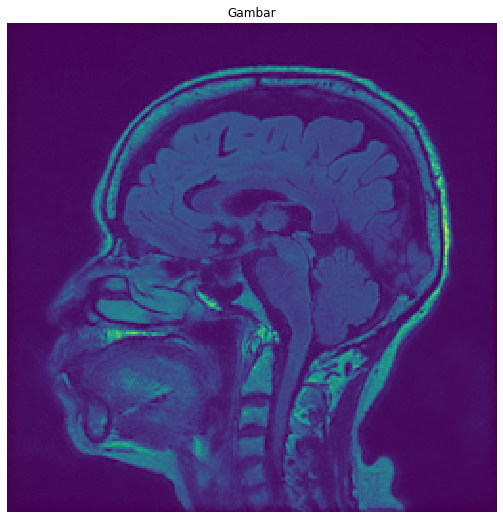

In [3]:
basepath ="../dicom/"
d = pydicom.read_file(basepath + "Z519")
file = np.array(d.pixel_array)
img = file
ShowImage('Gambar',img,'rgb')

In [4]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

# Gaussian thresholding

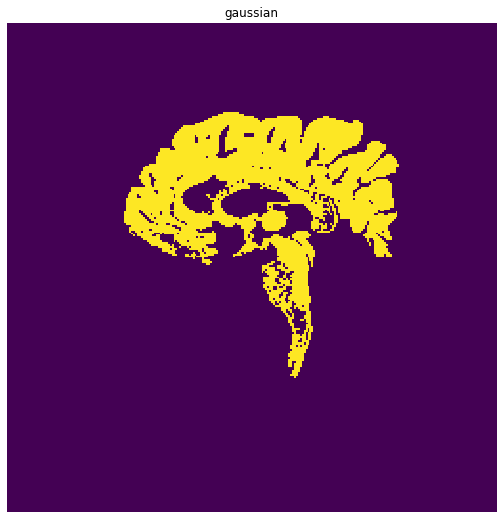

In [6]:
gaussian = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,115, 1)

foreground_value = 255
mask_gaussian = np.uint8(gaussian == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_gaussian, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
gauss = np.zeros_like(gaussian)
gauss[labels == largest_label] = foreground_value
ShowImage('gaussian',gauss,'rgb')

# invers otsu

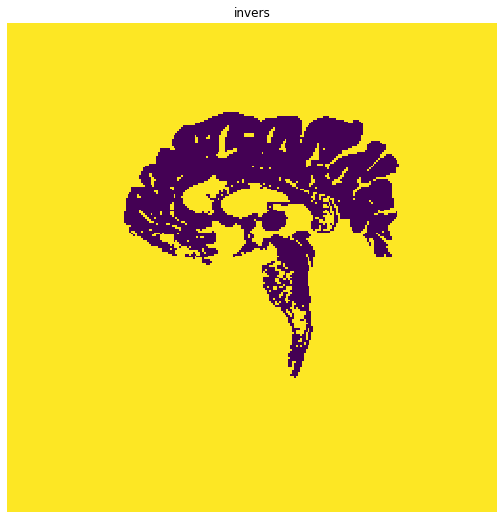

In [7]:
invers = cv2.bitwise_not(gauss)
ShowImage('invers',invers,'rgb')

# blackhat dari gauss

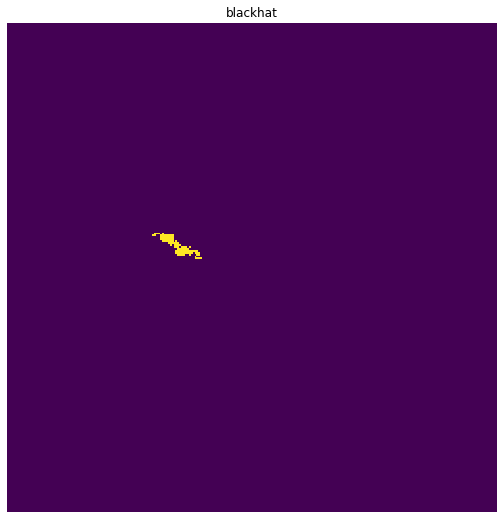

In [8]:
# blackhat
kernel = np.ones((5, 5), np.uint8)
blackhat = cv2.morphologyEx(gauss, cv2.MORPH_BLACKHAT, kernel)

foreground_value = 255
mask_gradient = np.uint8(blackhat == foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
black = np.zeros_like(blackhat)
black[labels == largest_label] = foreground_value
ShowImage('blackhat',black,'rgb')

# blackhat dari gauss_invers

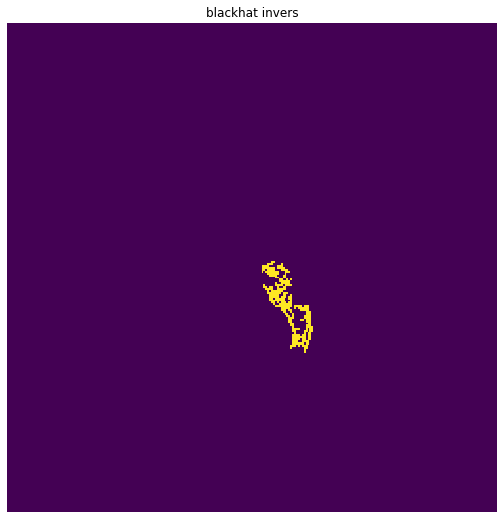

In [9]:
# blackhat
kernel = np.ones((5, 5), np.uint8)
blackhat = cv2.morphologyEx(invers, cv2.MORPH_BLACKHAT, kernel)

foreground_value = 255
mask_gradient = np.uint8(blackhat == foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
black_invers = np.zeros_like(blackhat)
black_invers[labels == largest_label] = foreground_value
ShowImage('blackhat invers',black_invers,'rgb')

# dilation from blackhat

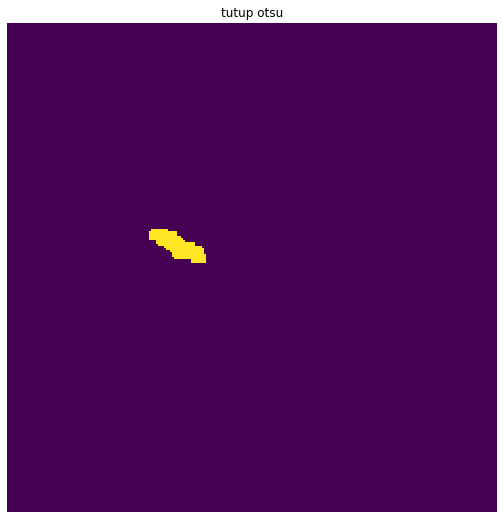

In [10]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(black,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_otsu = np.zeros_like(dilasi)
tutup_otsu[labels == largest_label] = foreground_value
ShowImage('tutup otsu',tutup_otsu,'rgb')


# dilation from blackhat invers

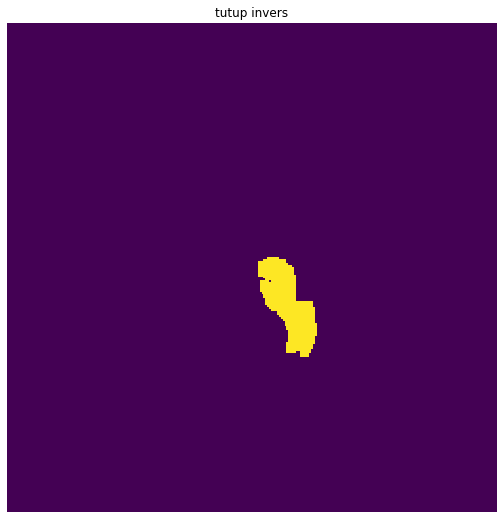

In [11]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(black_invers,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_invers = np.zeros_like(dilasi)
tutup_invers[labels == largest_label] = foreground_value
ShowImage('tutup invers',tutup_invers,'rgb')


# Skull Stripping

In [12]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask = tutup_otsu)
brain_pixels = skull_stripped_image[tutup_otsu == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[49 57 55 54 53 55 60 58 57 50 51 54 53 51 57 58 51 54 59 57 56 54 59 54
 54 57 52 47 44 47 51 49 50 54 56 58 61 65 53 61 61 49 44 50 50 47 48 45
 44 48 49 49 57 58 66 62 58 52 52 50 47 47 46 40 44 50 45 54 57 58 56 70
 68 69 65 58 50 44 45 50 44 43 48 44 52 52 53 60 55 63 58 52 48 46 43 45
 51 46 49 48 51 59 55 53 73 67 60 54 50 50 48 47 42 45 46 46 51 52 55 53
 51 57 56 56 72 63 59 55 57 52 47 50 48 45 45 47 52 56 55 58 55 49 51 61
 56 53 51 50 48 46 47 48 44 37 42 48 46 52 55 55 52 47 46 58 50 48 53 56
 50 45 46 39 33 36 43 47 48 46 51 51 52 51 43 50 53 52 47 48 41 38 43 42
 42 43 38 39 43 43 47 49 43 57 53 46 46 38 40 41 43 43 42 44 48 45 41 44
 48 46 50 57 52 48 45 42 42 48 47 44 47 49 47 42 43 52 49 48 13 29 40 47
 43 37 44 50 54 54 51 47 42 45 46 48 46 48 34 43 35 20 22 23 24 42 45 46
 48 39 42 31 34 51 43 23 25 30 26 27 40 83 82 18 19 17 19 20 41 75 93] Brain Pixels
[[49.]
 [57.]
 [55.]
 [54.]
 [53.]
 [55.]
 [60.]
 [58.]
 [57.]
 [50.]
 [51.]
 [54.]
 [53.]
 [51.]
 [57.]
 [58.]
 

# Segmented image

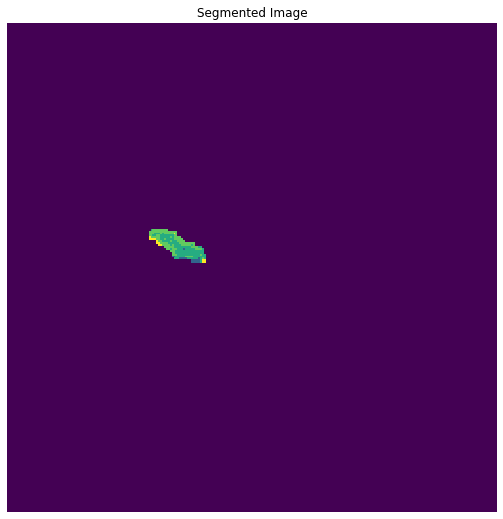

In [13]:
segmented_image = np.zeros_like(tutup_otsu)
segmented_image[tutup_otsu == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

# All in One Row

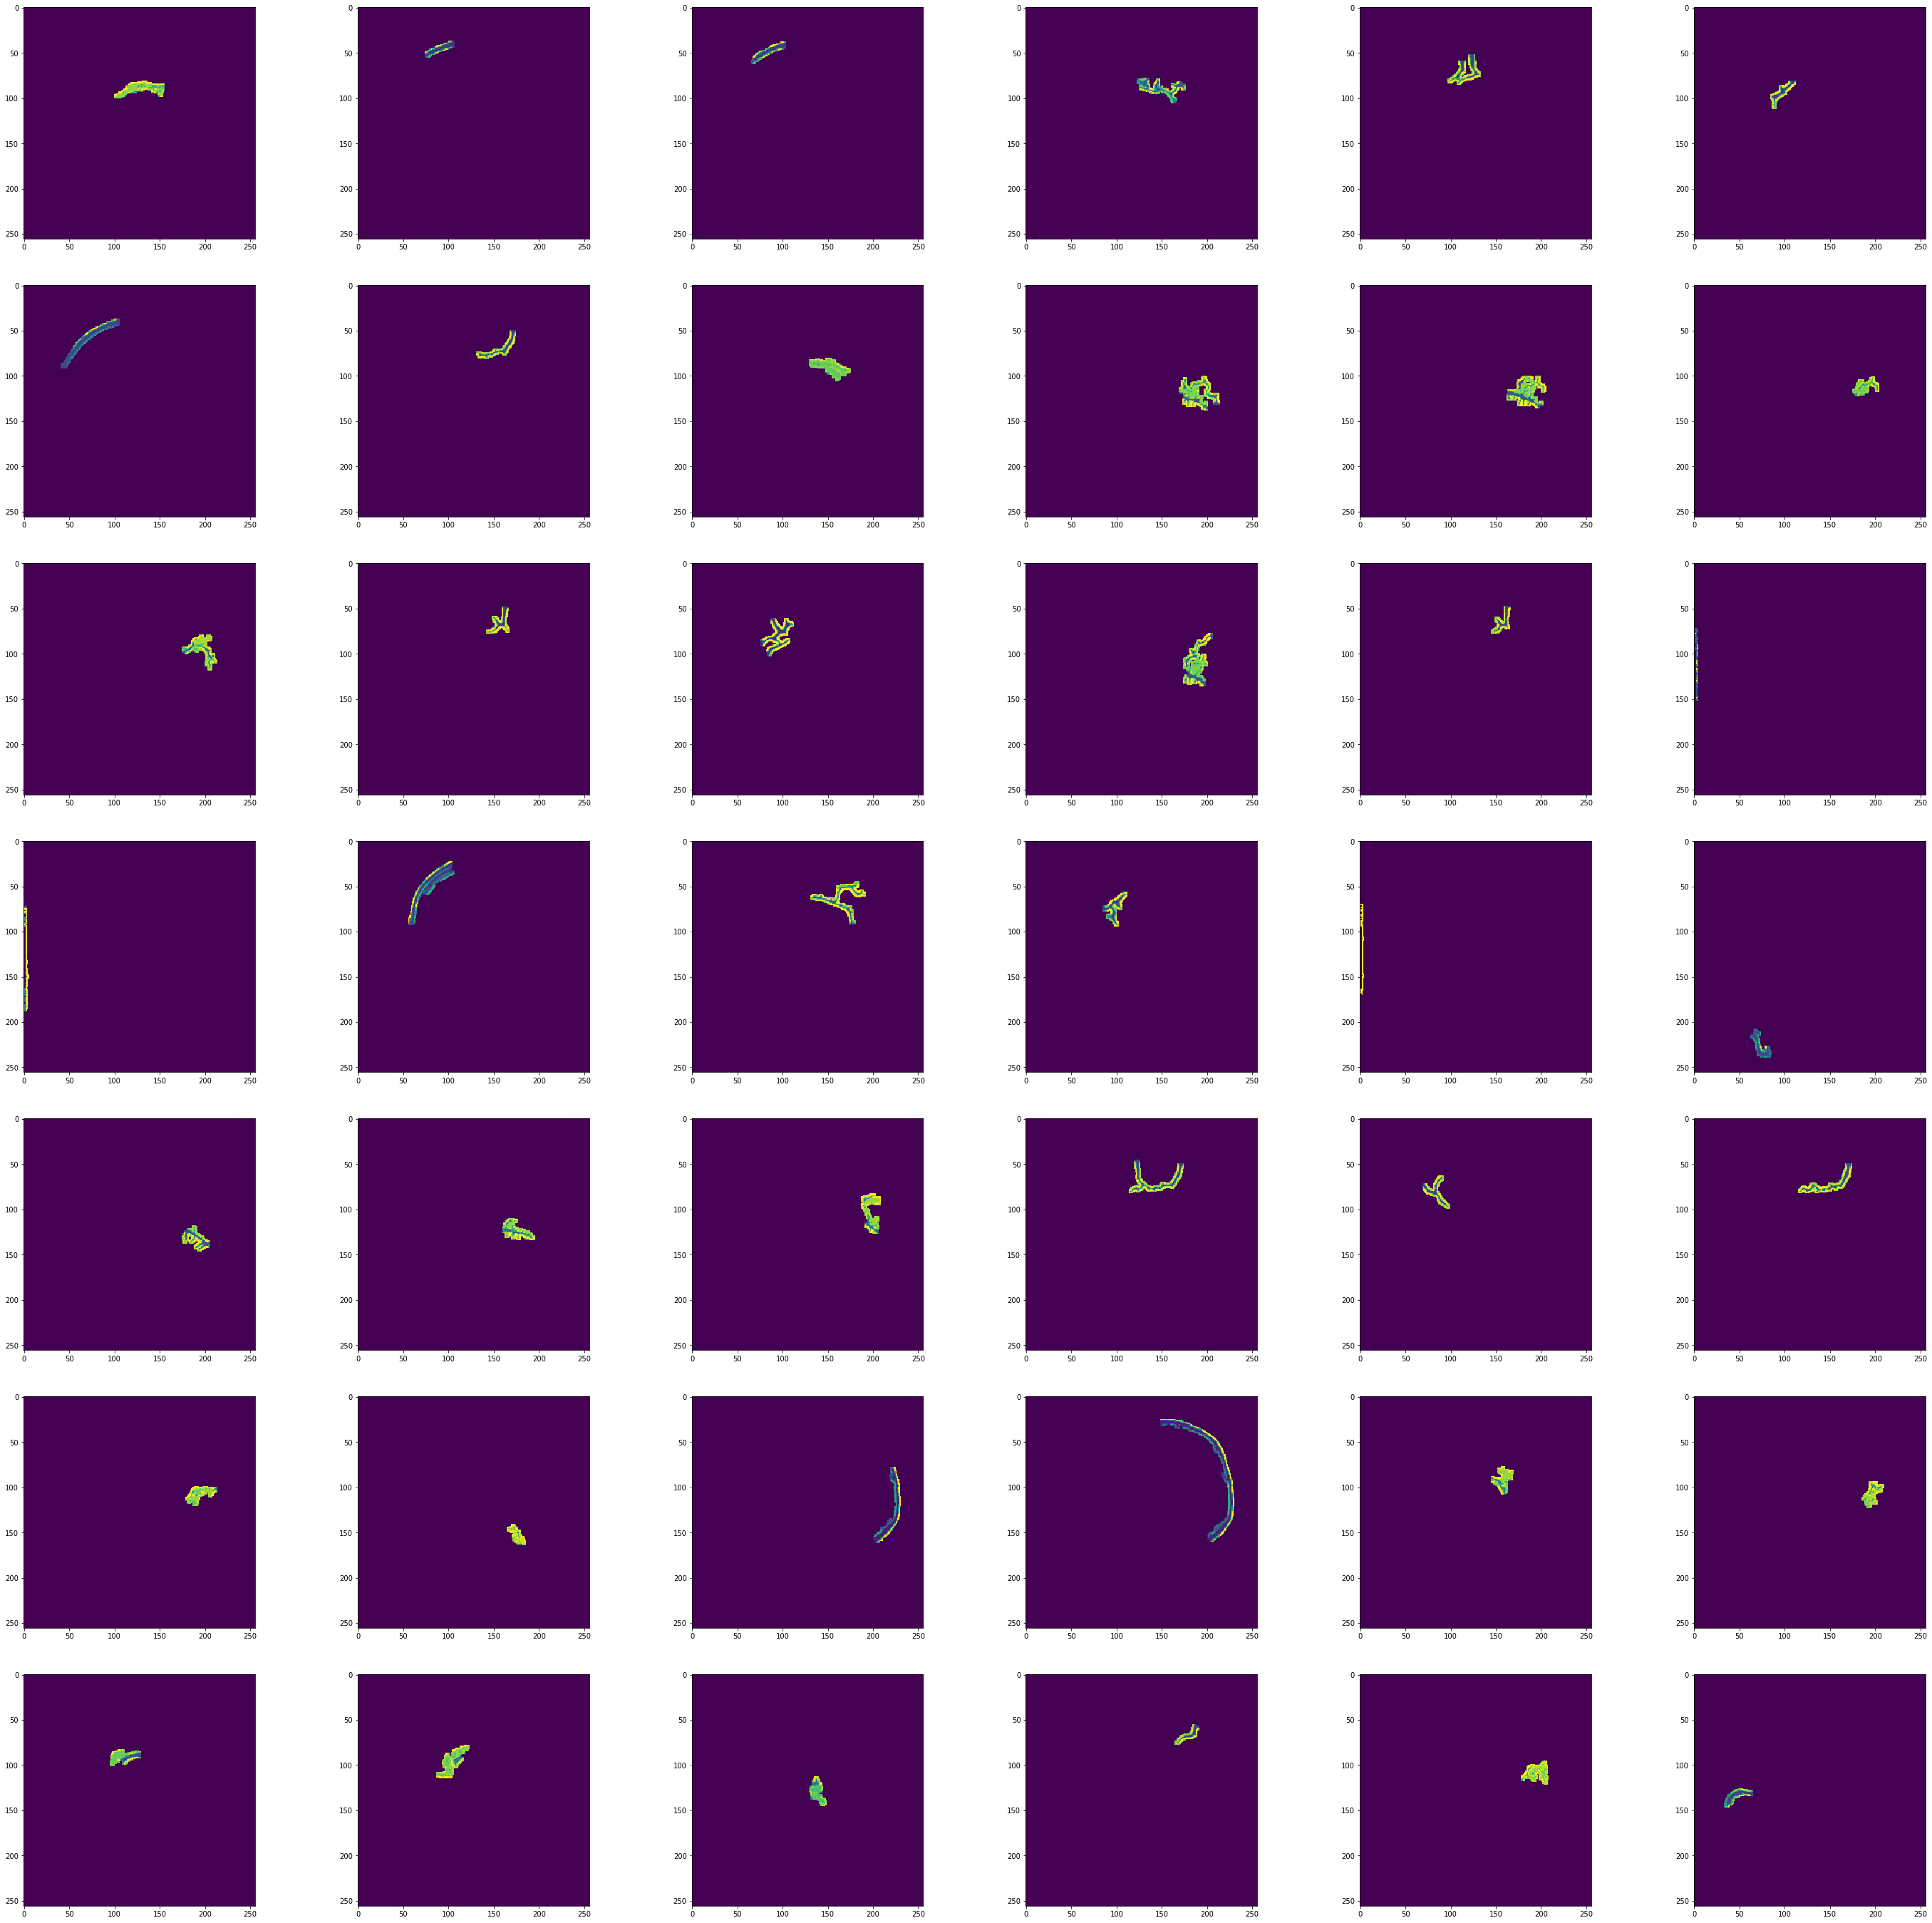

In [18]:
basepath ="../dicom/"
IMAGE_PATHS = os.listdir("../dicom/")
list_a = []

for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    
    gaussian = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,115, 1)

    foreground_value = 255
    mask_gaussian = np.uint8(gaussian == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_gaussian, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    gauss = np.zeros_like(gaussian)
    gauss[labels == largest_label] = foreground_value
    
    # blackhat
    kernel = np.ones((5, 5), np.uint8)
    blackhat = cv2.morphologyEx(gauss, cv2.MORPH_BLACKHAT, kernel)

    foreground_value = 255
    mask_gradient = np.uint8(blackhat == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    black = np.zeros_like(blackhat)
    black[labels == largest_label] = foreground_value
    
    bentukan = np.ones((5, 5), np.uint8)
    dilasi = cv2.dilate(black,bentukan,iterations = 1)

    foreground_value = 255
    mask_dilasi = np.uint8(dilasi >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    tutup_otsu = np.zeros_like(dilasi)
    tutup_otsu[labels == largest_label] = foreground_value
    

    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = tutup_otsu)
    brain_pixels = skull_stripped_image[tutup_otsu == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]
        
    segmented_image = np.zeros_like(tutup_otsu)
    segmented_image[tutup_otsu == foreground_value] = labels
    
    list_a.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_a[i])
plt.show()